# Recurrent Neural Networks (RNNs)

Until now, we have seen several types of neural networks, and they can be used for several problems. From inputs, they calculated an output as a prediction. One data type that is common to work with is __sequential__, such as time series and texts.

<img src="https://www.tradingview.com/x/BIMmjLxL/" width=600 align="center"/>

<img src="attachment:image.png" width=600 align="center"/>

In this type of data, the "past" values have a strong relationship with the "future" values, something that is not explicit in the architectures we have seen so far. To try to make this explicit, we will use __recurrent neural networks__.

In __recurrent neural networks__, the output of a hidden layer also works as the input of that same hidden layer.

<img src = "https://www.deeplearningbook.com.br/wp-content/uploads/2019/07/rnn.png" width=600>

But how does it work? Imagine that the output at a given time step is the input at the next time step.

We can understand the recurrent neural network as a combination of neural networks in sequence, so the predictions take into account what was passed previously. The most traditional RNNs can present a problem of long-term dependency, that is, the interval of previous data that is necessary to make the next predictions would be very large, which makes the development of the RNN unfeasible.

One way to avoid this type of problem would be to use RNNs that have memory storage capacity, ensuring that long-term dependencies are passed on. One of these networks is the __Long Short Time Memory (LSTM).__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## Applied Example of Temporal Series

Using the `covid_saopaulo.csv` database to develop a dynamic LSTM network and make death predictions using a 21-day time series snippet.

In [3]:
covidsp = pd.read_csv('../data/covid-saopaulo.csv', index_col = 'date', parse_dates = True)
covidsp.head()

,confirmed,deaths
date,,
2020-02-26,0,0
2020-02-27,0,0
2020-02-28,1,0
2020-02-29,0,0
2020-03-01,0,0


In [4]:
# drop the confirmed cases column
covidsp = covidsp.drop('confirmed', axis = 1)

In [6]:
# adjust the indices as a date_range
idx = pd.date_range(start = covidsp.index.min(), end = covidsp.index.max(), freq = 'D')
covidsp = covidsp.reindex(idx)

In [7]:
covidsp.fillna(0, inplace = True)

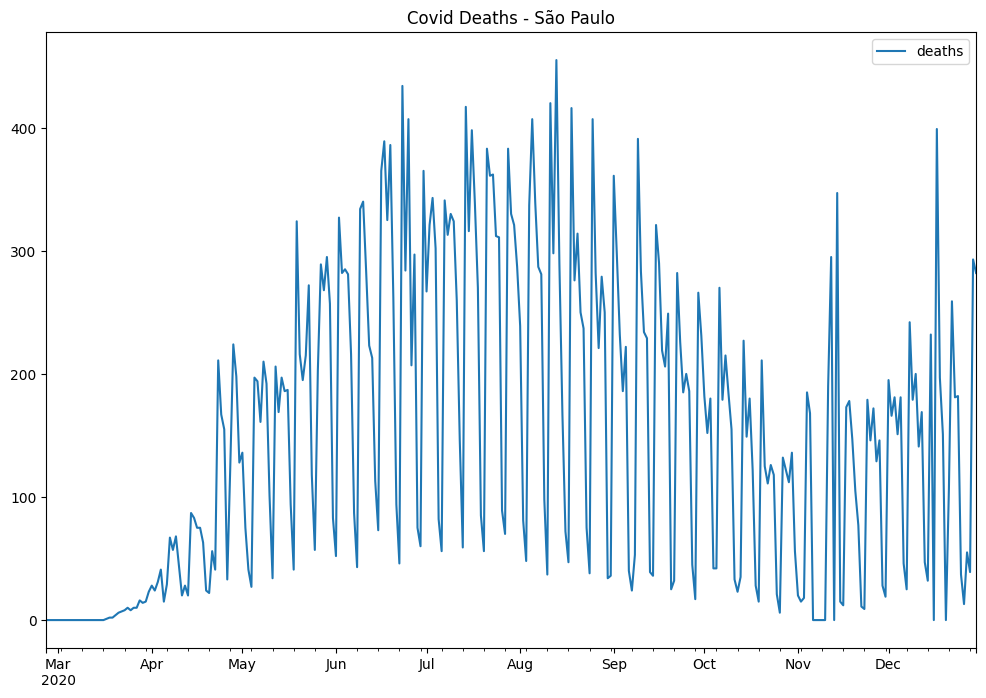

In [8]:
covidsp.plot(figsize=(12,8))
plt.title('Covid Deaths - São Paulo')
plt.show();

In [9]:
# Determina o tamanho total menos os 21 dias de teste
t_21_period = len(covidsp)-21
t_21_period

288

In [11]:
train = covidsp.iloc[:t_21_period]
test = covidsp.iloc[t_21_period:]

train.shape, test.shape

((288, 1), (21, 1))

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 7
n_features = 1

generator = TimeseriesGenerator(scaled_train, 
                                scaled_train, 
                                length = n_input, 
                                batch_size = 2)

In [15]:
# test first batch
X, y = generator[0]

In [16]:
# understand the batch split and the expected prediction
print('Expected data per batch and prediction')
print(f'First batch: \n{X.flatten()}');
print(f'Prediction: \n {y}');

Expected data per batch and prediction
First batch: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediction: 
 [[0.]
 [0.]]


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential([
            LSTM(100, activation='relu', input_shape=(n_input, n_features)),
            Dense(1, activation = 'sigmoid')])

In [18]:
# Sumario da Rede
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='mse')

model.fit(generator, epochs=10)

Epoch 1/10
141/141 [==============================] - 1s 2ms/step - loss: 0.0862
Epoch 2/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 3/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 4/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 5/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 6/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 7/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 8/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 9/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 10/10
141/141 [==============================] - 0s 2ms/step - loss: 0.0184


In [20]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [21]:
test_predictions

[array([0.3373391], dtype=float32),
 array([0.27619597], dtype=float32),
 array([0.29520684], dtype=float32),
 array([0.06764136], dtype=float32),
 array([0.0671275], dtype=float32),
 array([0.45667276], dtype=float32),
 array([0.33270547], dtype=float32),
 array([0.27352437], dtype=float32),
 array([0.2129863], dtype=float32),
 array([0.20353737], dtype=float32),
 array([0.05064641], dtype=float32),
 array([0.06926004], dtype=float32),
 array([0.38542876], dtype=float32),
 array([0.27221167], dtype=float32),
 array([0.21093468], dtype=float32),
 array([0.14593148], dtype=float32),
 array([0.12255905], dtype=float32),
 array([0.04155438], dtype=float32),
 array([0.06341128], dtype=float32),
 array([0.31203255], dtype=float32),
 array([0.20697924], dtype=float32)]

In [22]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[153.48929197],
       [125.66916779],
       [134.31911439],
       [ 30.77681657],
       [ 30.54301407],
       [207.78610483],
       [151.38098791],
       [124.45359007],
       [ 96.90876894],
       [ 92.6095055 ],
       [ 23.04411627],
       [ 31.51331749],
       [175.3700842 ],
       [123.85631025],
       [ 95.97528107],
       [ 66.39882445],
       [ 55.76436695],
       [ 18.9072413 ],
       [ 28.85213263],
       [141.97481051],
       [ 94.17555645]])

In [23]:
# save the predictions in the test dataframe
test['Predictions'] = true_predictions

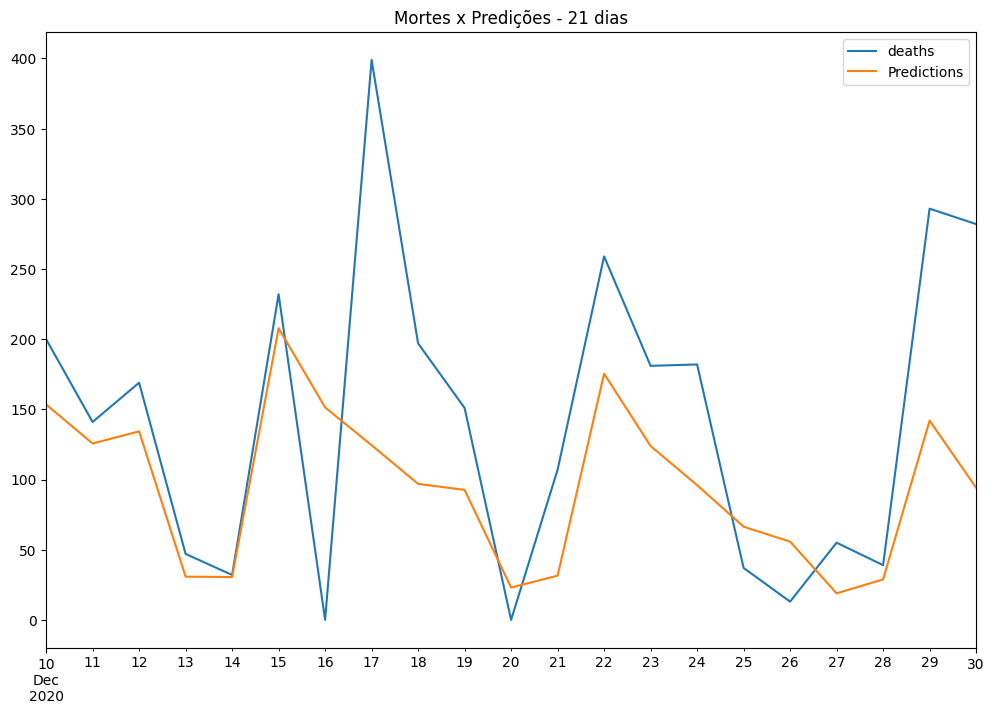

In [24]:
test.plot(figsize=(12,8))
plt.title('Mortes x Predições - 21 dias')
plt.show();

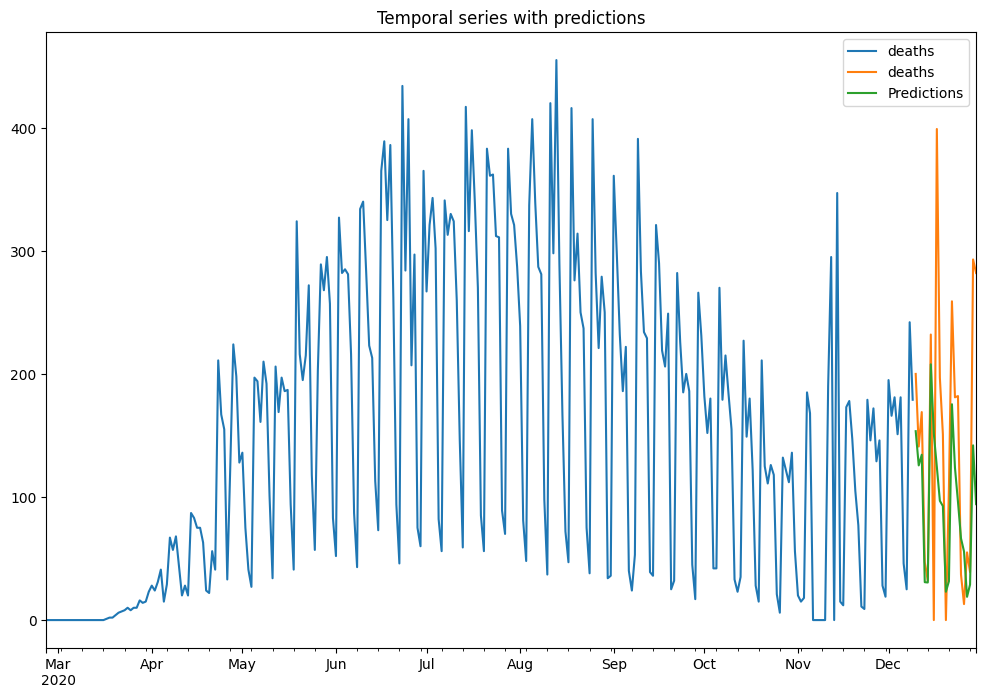

In [25]:
ax = train.plot(figsize=(12,8))
test.plot(ax=ax)
plt.title('Temporal series with predictions')
plt.show();